## Counting Spectra and Redshifts in DR1

Count the number of successful redshifts obtained in DR1 for the DR1 paper, in total and per tracer class.

Based on a script originally written by Anthony Kremin (LBNL, March 2023).

John Moustakas  
Siena College  
January 2025

### Setup

#### Import modules and set latex table formatting.

In [1]:
write_zenodo = True
write_paper_figures = True

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import fitsio

from astropy.io import fits
from astropy.table import Table, vstack
from astropy.io import ascii

In [3]:
import pathlib
pathlib.Path().resolve()

PosixPath('/global/common/software/desi/users/ioannis/dr1paper/nb')

#### Import survey-specific targeting information from [desitarget](https://github.com/desihub/desitarget) and define the surveys and tracers.

In [4]:
from desitarget.cmx.cmx_targetmask import cmx_mask as cmxmask
from desitarget.sv1.sv1_targetmask import desi_mask as sv1mask
from desitarget.sv2.sv2_targetmask import desi_mask as sv2mask
from desitarget.sv3.sv3_targetmask import desi_mask as sv3mask
from desitarget.targetmask import desi_mask

tracers = ['MWS', 'BGS', 'LRG', 'ELG', 'QSO', 'SCND']

desi_masks = {}
desi_masks['main'] = desi_mask
desi_masks['special'] = desi_mask
desi_masks['cmx'] = cmxmask
desi_masks['sv1'] = sv1mask
desi_masks['sv2'] = sv2mask
desi_masks['sv3'] = sv3mask

mask_colnames = {}
mask_colnames['main'] = 'DESI_TARGET'
mask_colnames['special'] = 'DESI_TARGET'
mask_colnames['cmx'] = 'CMX_TARGET'
mask_colnames['sv1'] = 'SV1_DESI_TARGET'
mask_colnames['sv2'] = 'SV2_DESI_TARGET'
mask_colnames['sv3'] = 'SV3_DESI_TARGET'

### Read and parse the redshift catalogs.

In [5]:
def read_zcat(specprod='iron'):
    """Read the redshift catalog for a given specprod.
    
    """
    if specprod == 'fuji':
        dr = 'edr'
    else:
        dr = 'dr1'
    
    readcols = np.array(['TARGETID', 'SURVEY', 'PROGRAM', 'OBJTYPE', 
                        'SPECTYPE', 'Z',  'ZWARN',  'DELTACHI2',
                        'COADD_FIBERSTATUS',  'ZCAT_NSPEC', 'ZCAT_PRIMARY',
                        'CMX_TARGET', 'DESI_TARGET', 'SV1_DESI_TARGET', 'SV2_DESI_TARGET', 'SV3_DESI_TARGET'])
    
    zcatdir = os.path.join(os.getenv('DESI_ROOT'), 'public', dr, 'spectro', 'redux', specprod, 'zcatalog')
    
    if specprod != 'fuji': # use patched guadalupe & iron catalogs
        zcatdir = os.path.join(zcatdir, 'v1')
    zcatfile = os.path.join(zcatdir, f'zall-pix-{specprod}.fits')
    
    allcols = np.array(fitsio.FITS(zcatfile)['ZCATALOG'].get_colnames())
    readcols = allcols[np.isin(allcols, readcols)]
    
    zcat = Table(fitsio.read(zcatfile, columns=readcols))
    print(f'Read {len(zcat):,d} rows from {zcatfile}')
        
    return zcat

In [6]:
def identify_tracers(input_zcat):
    """For each survey/program and tracer, use the appropriate bitmasks to 
    identify targeted objects that turned out to be the correct type.
    
    """
    # Initialize columns to keep track of tracers. Set to -1 so we can ensure we fill all rows
    zcat = input_zcat.copy()    
    for tracer in tracers:
        zcat.add_column(Table.Column(data=np.zeros(len(zcat))-1, 
                                     dtype=int, name=f"IS{tracer}"))

    for survey in sorted(set(zcat['SURVEY'])):
        #print(f'Identifying targets for survey: {survey}')
        desi_mask = desi_masks[survey]
        colname = mask_colnames[survey]
        bits = {}
        if survey == 'cmx':
            bgs = desi_mask.mask('MINI_SV_BGS_BRIGHT|SV0_BGS')
            elg = desi_mask.mask('MINI_SV_ELG|SV0_ELG')
            lrg = desi_mask.mask('MINI_SV_LRG|SV0_LRG')
            qso = desi_mask.mask('MINI_SV_QSO|SV0_QSO|SV0_QSO_Z5')
            mwsbitnames = 'STD_GAIA|SV0_STD_FAINT|SV0_STD_BRIGHT|STD_TEST|STD_CALSPEC|STD_DITHER|' \
                         + 'SV0_MWS_CLUSTER|SV0_MWS_CLUSTER_VERYBRIGHT|SV0_MWS|SV0_WD|BACKUP_BRIGHT|' \
                         + 'BACKUP_FAINT|M31_STD_BRIGHT|M31_H2PN|M31_GC|M31_QSO|M31_VAR|M31_BSPL|M31_M31cen|' \
                         + 'M31_M31out|ORI_STD_BRIGHT|ORI_QSO|ORI_ORI|ORI_HA|M33_STD_BRIGHT|M33_H2PN|M33_GC|' \
                         + 'M33_QSO|M33_M33cen|M33_M33out|SV0_MWS_FAINT|STD_DITHER_GAIA|STD_FAINT|STD_BRIGHT'
            mws = desi_mask.mask(mwsbitnames)
            sec = 2**70 # secondaries don't exist in cmx, so set it to above the 63rd bit
        else:
            bgs = desi_mask.mask('BGS_ANY')
            elg = desi_mask.mask('ELG')
            lrg = desi_mask.mask('LRG')
            qso = desi_mask.mask('QSO') 
            sec = desi_mask.mask('SCND_ANY')
            mws = desi_mask.mask('MWS_ANY|STD_FAINT|STD_WD|STD_BRIGHT')
    
        survey_selection = zcat['SURVEY'] == survey
        survey_subset = zcat[survey_selection]
    
        # Check if a {GALAXY,QSO,MWS} target was classified by Redrock as a galaxy, QSO, or star.
        GALTYPE = survey_subset['SPECTYPE'] == 'GALAXY'
        QSOTYPE = survey_subset['SPECTYPE'] == 'QSO'
        STARTYPE = survey_subset['SPECTYPE'] == 'STAR'
    
        # BGS
        PASSES_BIT_SEL = (survey_subset[colname] & bgs) > 0
        zcat['ISBGS'][survey_selection] = PASSES_BIT_SEL & GALTYPE
    
        # ELG
        PASSES_BIT_SEL = (survey_subset[colname] & elg) > 0
        zcat['ISELG'][survey_selection] = PASSES_BIT_SEL & GALTYPE
    
        # LRG
        PASSES_BIT_SEL = (survey_subset[colname] & lrg) > 0
        zcat['ISLRG'][survey_selection] = PASSES_BIT_SEL & GALTYPE
    
        # QSO
        PASSES_BIT_SEL = (survey_subset[colname] & qso) > 0
        zcat['ISQSO'][survey_selection] = PASSES_BIT_SEL & QSOTYPE
    
        # MWS
        PASSES_BIT_SEL = (survey_subset[colname] & mws) > 0
        zcat['ISMWS'][survey_selection] = PASSES_BIT_SEL & STARTYPE
    
        # Secondaries
        PASSES_BIT_SEL = (survey_subset[colname] & sec) > 0
        zcat['ISSCND'][survey_selection] = PASSES_BIT_SEL
    
        #zcat.remove_column(colname)
            
    # For each tracer, make sure none of the column entries are still the default (-1) then set column to be a boolean.
    for tracer in tracers:
        col = f"IS{tracer}"
        if np.any(zcat[col] < 0):
            raise ValueError("Found {np.sum(zcat[col]):,d} uncategorized tracers {tracer}")
        zcat[col] = Table.Column(data=zcat[col], name=col, dtype=bool)
        
    # Flag extragalactic targets.
    extragal = np.zeros(len(zcat), dtype=bool)
    for tracer in ['BGS', 'ELG', 'LRG', 'QSO']:
        if tracer in tracers:
            extragal |= zcat[f"IS{tracer}"].data
    zcat.add_column(Table.Column(data=extragal, name='ISEXG'))
        
    # Flag objects where targeting and Redrock agree on the category/class.
    anytracer = np.zeros(len(zcat), dtype=bool)
    for tracer in tracers:
        anytracer |= np.array(zcat[f"IS{tracer}"].data).astype(bool)
    zcat.add_column(Table.Column(data=anytracer, name='GOODTYPE'))
        
    return zcat

In [7]:
def parse_zcat(input_zcat, specprod='iron', remove_columns=False, verbose=True):
    """Parse a given redshift catalog.
    
    If groupsv=True then get the combined statistics for the cmx+sv? surveys separately from main and special.
    
    """
    def get_stats(zcat, survey):

        print('###############')
        print(f'{survey}')
        print('###############')
        
        # Count the raw numbers of objects before quality cuts
        if verbose:
            print(f"Raw number (science+sky) of zcat entries: {len(zcat):,}")
            for spectype in ['GALAXY', 'QSO', 'STAR']:
                print(f"Raw number of zcat entries for spectype '{spectype}': " + \
                      f"{np.sum(zcat['SPECTYPE'] == spectype):,}")    
            print()
        
        # Get the unique object numbers using the ZCAT_PRIMARY column
        unique_zcat = zcat[zcat['ZCAT_PRIMARY']]
        if verbose:
            print(f"Raw number (science+sky) of unique zcat entries: {len(unique_zcat):,}")
            for spectype in ['GALAXY', 'QSO', 'STAR']:
                print(f"Raw number of unique zcat entries for spectype '{spectype}': " + \
                      f"{np.sum(unique_zcat['SPECTYPE'] == spectype):,}")
            print()
        
        # Only keep science targets
        zcat = zcat[zcat['OBJTYPE'] == 'TGT']
        if remove_columns:
            zcat.remove_column('OBJTYPE')

        # Count the number of science objects without observing, hardware, or redshift fitting issues.
        # Remove all spectra with a ZWARN bit set
        zcat = zcat[zcat['ZWARN'] == 0]
        if remove_columns:
            zcat.remove_column('ZWARN')

        if verbose:
            print(f"Number of science (non-sky) targets with ZWARN==0: {len(zcat):,}")
            for spectype in ['GALAXY', 'QSO', 'STAR']:
                print(f"Number of science (non-sky) targets with ZWARN==0 for spectype '{spectype}': " + \
                      f"{np.sum(zcat['SPECTYPE'] == spectype):,}")
            print()
        
        unique_zcat = zcat[zcat['ZCAT_PRIMARY']]
        print(f"Number of unique science (non-sky) targets with ZWARN==0: {len(unique_zcat):,}")
        for spectype in ['GALAXY', 'QSO', 'STAR']:
            print(f"Number of unique science (non-sky) targets with ZWARN==0 for spectype '{spectype}': " + \
                  f"{np.sum(unique_zcat['SPECTYPE'] == spectype):,}")
        print()
        
        # Classify by tracer and extragalactic (or not).
        zcat = identify_tracers(zcat)
        
        #print(f"Number of correctly classified objects: {np.sum(zcat['GOODTYPE']):,}")
        #print(f"Number of unique correctly classified objects: {np.sum(zcat['GOODTYPE'] & zcat['ZCAT_PRIMARY']):,}")    
        #print()
        #print(f"Number of correctly classified extragalactic objects: {np.sum(zcat['ISEXG']):,}")
        #print(f"Number of unique correctly classified extragalactic objects: {np.sum(zcat['ISEXG'] & zcat['ZCAT_PRIMARY']):,}")    
        #print()

        return zcat


    zcat_groupsurvey = {}
 
    print(f'specprod={specprod}')
    for survey in ['sv', 'special', 'main']:
        if survey == 'sv':
            I = np.where((input_zcat['SURVEY'] != 'main') * (input_zcat['SURVEY'] != 'special'))[0]
            if len(I) == 0:
                continue
            zcat_groupsurvey[survey] = get_stats(input_zcat[I], 'sv')
        elif survey == 'special':
            I = np.where(input_zcat['SURVEY'] == 'special')[0]
            if len(I) == 0:
                continue
            zcat_groupsurvey[survey] = get_stats(input_zcat[I], 'special')
        else:
            for program in ['backup', 'bright', 'dark']:
                I = np.where((input_zcat['SURVEY'] == 'main') * (input_zcat['PROGRAM'] == program))[0]
                if len(I) == 0:
                    continue
                zcat_groupsurvey[survey] = get_stats(input_zcat[I], f'main/{program}')
                
            I = np.where(input_zcat['SURVEY'] == 'main')[0]
            if len(I) == 0:
                continue
            zcat_groupsurvey[survey] = get_stats(input_zcat[I], 'main')
            
    return zcat_groupsurvey

#### Guadalupe (DR1 Supplement)

In [8]:
%time zcat_guadalupe = read_zcat(specprod='guadalupe')

Read 3,212,502 rows from /global/cfs/cdirs/desi/public/dr1/spectro/redux/guadalupe/zcatalog/v1/zall-pix-guadalupe.fits
CPU times: user 2.74 s, sys: 2.24 s, total: 4.98 s
Wall time: 5.35 s


In [9]:
zcat_groupsurvey_guadalupe = parse_zcat(zcat_guadalupe, specprod='guadalupe', verbose=True)

specprod=guadalupe
###############
special
###############
Raw number (science+sky) of zcat entries: 24,412
Raw number of zcat entries for spectype 'GALAXY': 19,519
Raw number of zcat entries for spectype 'QSO': 1,178
Raw number of zcat entries for spectype 'STAR': 3,715

Raw number (science+sky) of unique zcat entries: 24,182
Raw number of unique zcat entries for spectype 'GALAXY': 19,411
Raw number of unique zcat entries for spectype 'QSO': 1,175
Raw number of unique zcat entries for spectype 'STAR': 3,596

Number of science (non-sky) targets with ZWARN==0: 15,104
Number of science (non-sky) targets with ZWARN==0 for spectype 'GALAXY': 11,689
Number of science (non-sky) targets with ZWARN==0 for spectype 'QSO': 959
Number of science (non-sky) targets with ZWARN==0 for spectype 'STAR': 2,456

Number of unique science (non-sky) targets with ZWARN==0: 14,991
Number of unique science (non-sky) targets with ZWARN==0 for spectype 'GALAXY': 11,688
Number of unique science (non-sky) targets 

#### Iron (DR1)

In [10]:
%time zcat_iron = read_zcat(specprod='iron')

Read 28,425,963 rows from /global/cfs/cdirs/desi/public/dr1/spectro/redux/iron/zcatalog/v1/zall-pix-iron.fits
CPU times: user 26.8 s, sys: 24.3 s, total: 51.2 s
Wall time: 53.1 s


In [11]:
zcat_groupsurvey_iron = parse_zcat(zcat_iron, specprod='iron', verbose=True)

specprod=iron
###############
sv
###############
Raw number (science+sky) of zcat entries: 2,791,223
Raw number of zcat entries for spectype 'GALAXY': 2,156,114
Raw number of zcat entries for spectype 'QSO': 108,874
Raw number of zcat entries for spectype 'STAR': 526,235

Raw number (science+sky) of unique zcat entries: 2,590,505
Raw number of unique zcat entries for spectype 'GALAXY': 2,006,184
Raw number of unique zcat entries for spectype 'QSO': 98,496
Raw number of unique zcat entries for spectype 'STAR': 485,825

Number of science (non-sky) targets with ZWARN==0: 1,757,706
Number of science (non-sky) targets with ZWARN==0 for spectype 'GALAXY': 1,141,467
Number of science (non-sky) targets with ZWARN==0 for spectype 'QSO': 97,908
Number of science (non-sky) targets with ZWARN==0 for spectype 'STAR': 518,331

Number of unique science (non-sky) targets with ZWARN==0: 1,613,846
Number of unique science (non-sky) targets with ZWARN==0 for spectype 'GALAXY': 1,046,508
Number of unique 

#### Fuji (EDR)

Reproduce the numbers in the EDR paper.

In [12]:
%time zcat_fuji = read_zcat(specprod='fuji')

Read 2,847,435 rows from /global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/zcatalog/zall-pix-fuji.fits
CPU times: user 2.56 s, sys: 2.2 s, total: 4.76 s
Wall time: 5.06 s


In [13]:
zcat_groupsurvey_fuji = parse_zcat(zcat_fuji, specprod='fuji', verbose=True)

specprod=fuji
###############
sv
###############
Raw number (science+sky) of zcat entries: 2,796,564
Raw number of zcat entries for spectype 'GALAXY': 1,677,282
Raw number of zcat entries for spectype 'QSO': 113,597
Raw number of zcat entries for spectype 'STAR': 1,005,685

Raw number (science+sky) of unique zcat entries: 2,709,326
Raw number of unique zcat entries for spectype 'GALAXY': 1,623,903
Raw number of unique zcat entries for spectype 'QSO': 108,317
Raw number of unique zcat entries for spectype 'STAR': 977,106

Number of science (non-sky) targets with ZWARN==0: 1,755,608
Number of science (non-sky) targets with ZWARN==0 for spectype 'GALAXY': 1,148,457
Number of science (non-sky) targets with ZWARN==0 for spectype 'QSO': 91,443
Number of science (non-sky) targets with ZWARN==0 for spectype 'STAR': 515,708

Number of unique science (non-sky) targets with ZWARN==0: 1,699,018
Number of unique science (non-sky) targets with ZWARN==0 for spectype 'GALAXY': 1,116,887
Number of uniq

In [14]:
def latex_N_subscript(subscript):
    return r'$\mathrm{N}_{\mathrm{'+subscript+r'}}$'

def format_number(number):
    return f"{number:,}"

def populate_row(survey, subset_table, tracers):
    row = {'Survey': survey}
    for tracer in tracers:
        if tracer == 'Total':
            colname = 'ZCAT_PRIMARY'
        else:
            colname = f"IS{tracer}"
        num = int(np.sum(subset_table[colname]))
        if tracer == 'Total':
            row[tracer] = format_number(num)
        else:
            #if num == 0:
            #    row[latex_N_subscript(tracer)] = r'\nodata'
            #else:
            row[latex_N_subscript(tracer)] = format_number(num)                
    return row

def build_goodredshift_table(zcat_groupsurvey, specprod):
    """Build the table of good redshifts split by survey and tracer for the paper.
    
    """
    colnames = ['Survey'] + [latex_N_subscript(subscript) for subscript in tracers] + ['Total']
    goodredshifttab = Table(names=colnames, dtype=['S10']*len(colnames))

    zcat_bysurvey = {}
    for groupsurvey in zcat_groupsurvey.keys():
        print(f'Working on group survey {groupsurvey}')
        zcat = zcat_groupsurvey[groupsurvey]
        zcat = zcat[zcat['ZCAT_PRIMARY']] # unique objects
        if groupsurvey == 'sv':
            for survey in ['cmx', 'sv1', 'sv2', 'sv3']:
                zcat_onesurvey = zcat[zcat['SURVEY'] == survey]
                if len(zcat_onesurvey) > 0:
                    zcat_bysurvey[survey] = zcat_onesurvey
                    goodredshifttab.add_row(populate_row(survey, zcat_onesurvey, tracers + ['Total']))
            zcat_bysurvey[groupsurvey] = zcat
            goodredshifttab.add_row(populate_row('Total', zcat, tracers + ['Total']))                    
        elif groupsurvey == 'special':
            zcat_onesurvey = zcat[zcat['SURVEY'] == groupsurvey]
            if len(zcat_onesurvey) > 0:
                zcat_bysurvey[groupsurvey] = zcat_onesurvey
                goodredshifttab.add_row(populate_row(groupsurvey, zcat_onesurvey, tracers + ['Total']))
        elif groupsurvey == 'main':
            for program in ['backup', 'bright', 'dark']:
                survey = f'{groupsurvey}/{program}'
                zcat_onesurvey = zcat[(zcat['SURVEY'] == groupsurvey) * (zcat['PROGRAM'] == program)]
                if len(zcat_onesurvey) > 0:
                    zcat_bysurvey[survey] = zcat_onesurvey
                    goodredshifttab.add_row(populate_row(survey, zcat_onesurvey, tracers + ['Total']))
            zcat_bysurvey[groupsurvey] = zcat
            goodredshifttab.add_row(populate_row('Total', zcat, tracers + ['Total']))

    #ascii.write(goodredshifttab, format='aastex', latexdict=latex_dict)
    
    print(r'\begin{deluxetable*}{cccccccc}')
    print(r'\tablecaption{Write me.}')
    print(r'\tablehead{')
    print(' & '.join(['\colhead{Sample}'] + [r'\colhead{$\mathrm{N}_{\mathrm{'+subscript+r'}}$}' for subscript in tracers] + 
                     ['\colhead{Total}']))
    print('}')
    print(r'\startdata')
    for irow in range(len(goodredshifttab)):
        survey = goodredshifttab[irow][colnames[0]]
        #if specprod == 'iron':
        if survey == 'cmx':
            print(r'\multicolumn{8}{c}{Commissioning \& Survey Validation} \\')
            print(r'\hline')
        elif survey == 'special':
            print(r'\hline')
            print(r'\multicolumn{8}{c}{Special Observations} \\')
            print(r'\hline')
        elif ((specprod == 'guadalupe' and survey == 'main/bright') or
              (specprod == 'iron' and survey == 'main/backup')):
            print(r'\hline')
            print(r'\multicolumn{8}{c}{Main Survey} \\')
            print(r'\hline')
        print(r' & '.join([survey] + [f'{goodredshifttab[irow][col]}' for col in colnames[1:]])+r' \\')
    print(r'\hline')
    print(r'\enddata')
    print(r'\end{deluxetable*}')
    
    return zcat_bysurvey

### Generate tables for the paper.

For each survey, count the number of unique targets of each tracer and output to a table.

#### Guadalupe (DR1 Supplement)

In [15]:
zcat_bysurvey_guadalupe = build_goodredshift_table(zcat_groupsurvey_guadalupe, specprod='guadalupe')

Working on group survey special
Working on group survey main
\begin{deluxetable*}{cccccccc}
\tablecaption{Write me.}
\tablehead{
\colhead{Sample} & \colhead{$\mathrm{N}_{\mathrm{MWS}}$} & \colhead{$\mathrm{N}_{\mathrm{BGS}}$} & \colhead{$\mathrm{N}_{\mathrm{LRG}}$} & \colhead{$\mathrm{N}_{\mathrm{ELG}}$} & \colhead{$\mathrm{N}_{\mathrm{QSO}}$} & \colhead{$\mathrm{N}_{\mathrm{SCND}}$} & \colhead{Total}
}
\startdata
\hline
\multicolumn{8}{c}{Special Observations} \\
\hline
special & 2,023 & 6,272 & 354 & 2,157 & 846 & 4,257 & 14,991 \\
\hline
\multicolumn{8}{c}{Main Survey} \\
\hline
main/bright & 252,091 & 1,041,596 & 47,375 & 199 & 682 & 100,503 & 1,325,027 \\
main/dark & 29,452 & 41,538 & 323,371 & 315,211 & 226,964 & 225,943 & 1,041,689 \\
Total & 281,543 & 1,083,134 & 370,746 & 315,410 & 227,646 & 326,446 & 2,366,716 \\
\hline
\enddata
\end{deluxetable*}


#### Iron (DR1)

In [16]:
zcat_bysurvey_iron = build_goodredshift_table(zcat_groupsurvey_iron, specprod='iron')

Working on group survey sv
Working on group survey special
Working on group survey main
\begin{deluxetable*}{cccccccc}
\tablecaption{Write me.}
\tablehead{
\colhead{Sample} & \colhead{$\mathrm{N}_{\mathrm{MWS}}$} & \colhead{$\mathrm{N}_{\mathrm{BGS}}$} & \colhead{$\mathrm{N}_{\mathrm{LRG}}$} & \colhead{$\mathrm{N}_{\mathrm{ELG}}$} & \colhead{$\mathrm{N}_{\mathrm{QSO}}$} & \colhead{$\mathrm{N}_{\mathrm{SCND}}$} & \colhead{Total}
}
\startdata
\multicolumn{8}{c}{Commissioning \& Survey Validation} \\
\hline
cmx & 469 & 247 & 1,040 & 734 & 292 & 0 & 3,173 \\
sv1 & 159,115 & 128,921 & 62,706 & 109,420 & 29,387 & 59,538 & 527,927 \\
sv2 & 8,954 & 37,456 & 21,053 & 11,732 & 11,364 & 0 & 89,925 \\
sv3 & 280,253 & 219,213 & 127,876 & 295,831 & 32,843 & 69,811 & 992,821 \\
Total & 448,791 & 385,837 & 212,675 & 417,717 & 73,886 & 129,349 & 1,613,846 \\
\hline
\multicolumn{8}{c}{Special Observations} \\
\hline
special & 42,690 & 31,303 & 3,778 & 4,407 & 2,599 & 58,252 & 141,473 \\
\hline
\multicol

#### Fuji (EDR)

Reproduce the numbers in the EDR paper.

In [17]:
zcat_bysurvey_fuji = build_goodredshift_table(zcat_groupsurvey_fuji, specprod='fuji')

Working on group survey sv
Working on group survey special
\begin{deluxetable*}{cccccccc}
\tablecaption{Write me.}
\tablehead{
\colhead{Sample} & \colhead{$\mathrm{N}_{\mathrm{MWS}}$} & \colhead{$\mathrm{N}_{\mathrm{BGS}}$} & \colhead{$\mathrm{N}_{\mathrm{LRG}}$} & \colhead{$\mathrm{N}_{\mathrm{ELG}}$} & \colhead{$\mathrm{N}_{\mathrm{QSO}}$} & \colhead{$\mathrm{N}_{\mathrm{SCND}}$} & \colhead{Total}
}
\startdata
\multicolumn{8}{c}{Commissioning \& Survey Validation} \\
\hline
cmx & 468 & 247 & 1,037 & 761 & 275 & 0 & 3,185 \\
sv1 & 162,555 & 133,421 & 65,453 & 111,246 & 28,996 & 59,514 & 539,165 \\
sv2 & 9,968 & 46,476 & 22,018 & 12,269 & 10,932 & 0 & 101,022 \\
sv3 & 292,634 & 247,745 & 135,384 & 309,647 & 33,005 & 74,313 & 1,055,646 \\
Total & 465,625 & 427,889 & 223,892 & 433,923 & 73,208 & 133,827 & 1,699,018 \\
\hline
\multicolumn{8}{c}{Special Observations} \\
\hline
special & 822 & 869 & 3,426 & 3,741 & 2,871 & 3,321 & 12,986 \\
\hline
\enddata
\end{deluxetable*}


### Generate figures for the paper.

For each survey, plot the N(z) distribution for the DESI main tracer classes.

In [18]:
def get_N_summary_str(number):
    """Simple function to nicely print number of spectra in a sample."""
    norm = np.round(number, 1-len(str(number))+1)
    if number < 1e3:
        return str(number)
    elif number > 1e3 and number < 1e6:
        return f'{number // int(1e3):d}k'
    elif number > 1e6 and number < 1e7:
        return f'{norm / 1e6:.2g}M'
    else:
        #print(number, norm)
        return f'{norm / 1e6:.3g}M'

In [19]:
def generate_nofz(zcat, title=None, png=None, write_paper_figures=False, write_zenodo=False):
    """Generate redshift histograms split by Redrock type and tracer.
    
    """
    import matplotlib.gridspec as gridspec
    from matplotlib.patches import Patch

    colors = {'STAR': 'tan', 'MWS': 'skyblue', 'BGS': 'forestgreen', 
              'LRG': 'red', 'ELG': 'blue', 'QSO': 'purple', 
              'GALAXY': 'gray'}
    
    stellar_lims = 400. * np.array([-1., 1.])
    extragal_lims = [-0.06, 4.2]
    nbins = 175

    fig = plt.figure(figsize=(9.5, 5))
    gs = fig.add_gridspec(nrows=2, ncols=2)#, height_ratios=[0.5, 1.])

    starax = fig.add_subplot(gs[:, 0])
    galax = fig.add_subplot(gs[0, 1])
    qsoax = fig.add_subplot(gs[1, 1])

    for spectype, tracer, lims, ax in zip(
        ['STAR', 'GALAXY', 'QSO'], 
        ['MWS', _, 'QSO'],
        [stellar_lims, extragal_lims, extragal_lims],
        [starax, galax, qsoax]):

        I = zcat['SPECTYPE'] == spectype
        zs = zcat['Z'][I].value
        if spectype == 'STAR':
            zs *= 3e5
        
        bins = np.arange(lims[0], lims[1], nbins)
        n_all, bins_all = np.histogram(zs, bins=nbins, range=lims)
        norm_all = np.max(n_all)
        norm_all = np.round(norm_all, 1-len(str(norm_all))+1)
        ax.stairs(n_all / norm_all, bins_all, color='gray', fill=True, 
                  alpha=0.5)#, label=label)
        ax.stairs(n_all / norm_all, bins_all, color='k')

        if write_zenodo:
            zenodo = dict()
            if spectype == 'STAR':
                zenodo['VBIN'] = (bins_all[0:-1] + bins_all[1:])/2
            else:
                zenodo['ZBIN'] = (bins_all[0:-1] + bins_all[1:])/2              
            zenodo['ALL'] = n_all
        
        handles = []
        label = f'{get_N_summary_str(np.sum(I))} RR {spectype}'#+r'$_{\text{RR}}$'
        handles.append(Patch(facecolor='gray', edgecolor='k', label=label, fill=True))
        
        if spectype == 'GALAXY':
            for itrace, tracer in enumerate(['BGS', 'LRG', 'ELG'][::-1]):
                zs = zcat['Z'][zcat[f'IS{tracer}']].value
                label = f'{get_N_summary_str(len(zs))} {tracer}'

                handles.append(Patch(color=colors[tracer], label=label, fill=True))
                       
                n_one, bins_one = np.histogram(zs, bins=nbins, range=lims)
                ax.stairs(n_one / norm_all, bins_one, color=colors[tracer], 
                          alpha=0.5, fill=True)#, label=label)

                if write_zenodo:
                    zenodo[tracer] = n_one
        else:
            zs = zcat['Z'][zcat[f'IS{tracer}']].value
            if tracer == 'MWS':
                zs *= 3e5
                
            n_tracer, bins_tracer = np.histogram(zs, bins=nbins, range=lims)

            label = f'{get_N_summary_str(len(zs))} {tracer}'
            handles.append(Patch(color=colors[tracer], label=label, fill=True))

            ax.stairs(n_tracer / norm_all, bins_tracer, color=colors[tracer], 
                      fill=True, alpha=0.5)#, label=label)
            ax.stairs(n_tracer / norm_all, bins_tracer, alpha=1, fill=False,
                      color=colors[tracer])
            
            if write_zenodo:
                zenodo[tracer] = n_tracer
        
        if spectype == 'STAR':
            xlabel = 'Radial Velocity (km / s)'
            ax.set_xlabel(xlabel)
            ax.set_ylabel(f'Fraction of {spectype}')
            ax.set_yticklabels([])
        else:
            if spectype == 'QSO':
                xlabel = 'Redshift'
                ax.set_xlabel(xlabel)
            ax.set_yticklabels([])
            ax_twin = ax.twinx()
            ax_twin.set_ylabel(f'Fraction of {spectype}')
            ax_twin.set_yticklabels([])

        if spectype == 'STAR':
            ax.legend(handles=handles, loc='upper left')
        else:
            ax.legend(handles=handles, loc='upper right')

        ax.set_ylim(0, 1.05)
        ax.margins(0)

        # write out the Zenodo files, as requested
        if write_zenodo:
            if spectype == 'STAR':
                zenodofile = f'../zenodo/nofv_{spectype}.csv'
            else:
                zenodofile = f'../zenodo/nofz_{spectype}.csv'

            data = Table()
            for key in zenodo:
                data[key] = zenodo[key]
            data.write(zenodofile, overwrite=True)
            print(f'Wrote {zenodofile}')

    if title:
        fig.suptitle(title, y=0.96)
    
    fig.subplots_adjust(hspace=0.05, wspace=0.08, top=0.9, left=0.07, right=0.93)
    plt.show()
    
    if png and write_paper_figures:
        print(f'Writing {png}')
        fig.savefig(png)
        plt.close()

#### Iron (DR1)

Wrote ../zenodo/nofv_STAR.csv
Wrote ../zenodo/nofz_GALAXY.csv
Wrote ../zenodo/nofz_QSO.csv


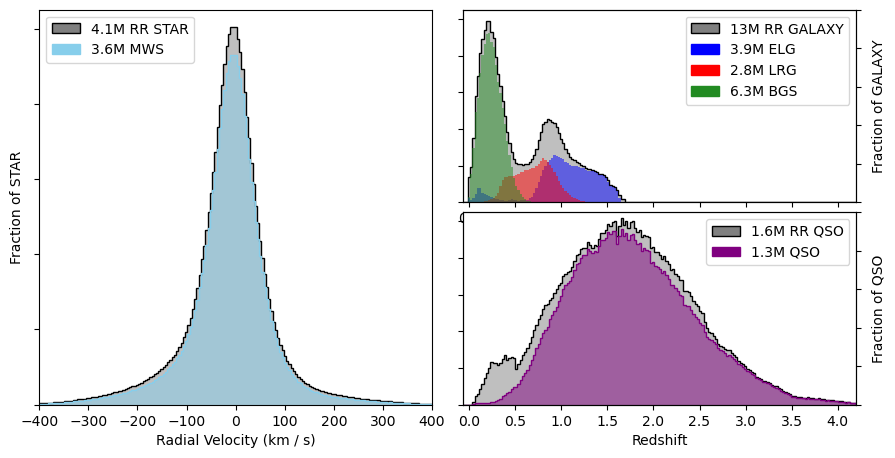

Writing ../figures/nofz-iron-main.png


In [20]:
generate_nofz(zcat_bysurvey_iron['main'], png='../figures/nofz-iron-main.png', 
              write_paper_figures=write_paper_figures, write_zenodo=write_zenodo)

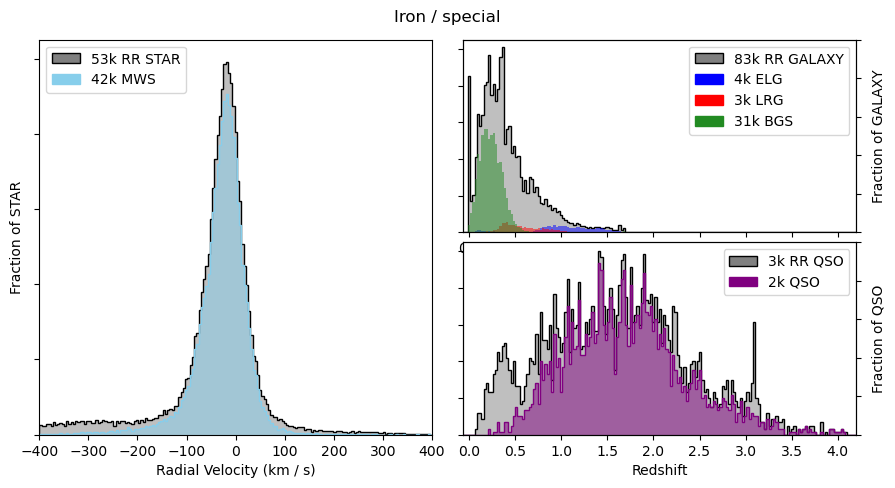

In [21]:
generate_nofz(zcat_bysurvey_iron['special'], title='Iron / special', png='../figures/nofz-iron-special.png')

#### Guadalupe (DR1 Supplement)

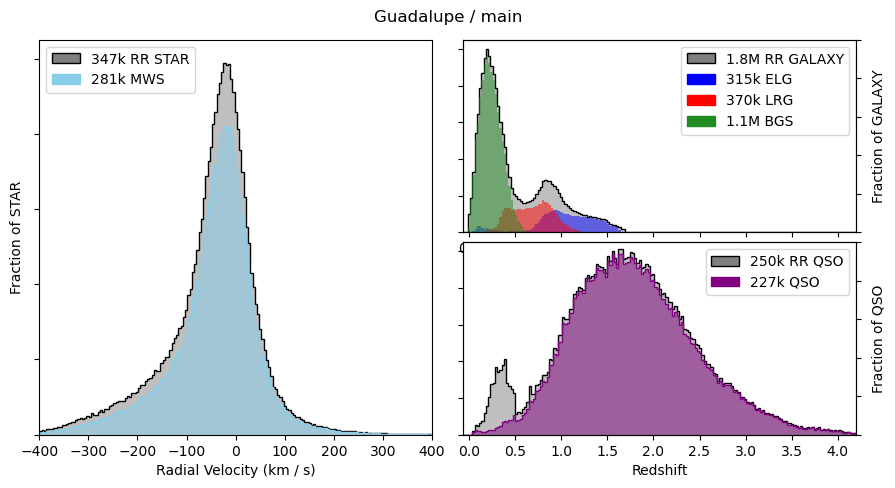

In [22]:
generate_nofz(zcat_bysurvey_guadalupe['main'], title='Guadalupe / main', png='../figures/nofz-guadalupe-main.png')

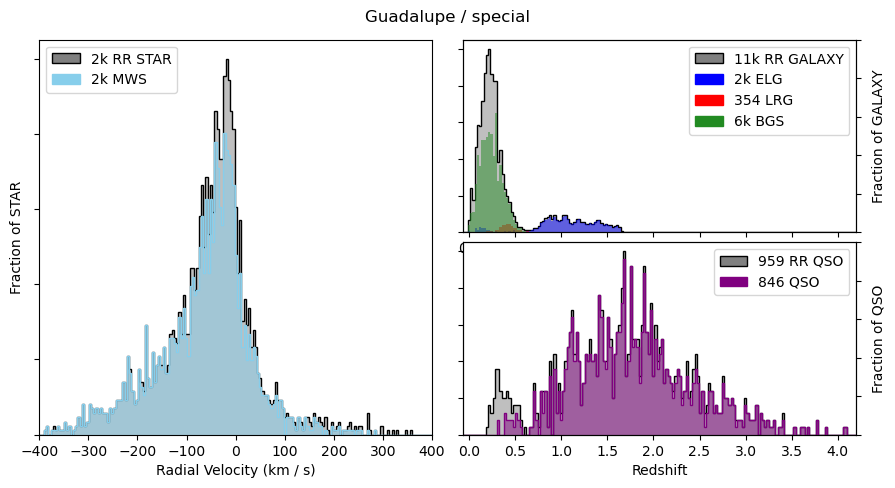

In [23]:
generate_nofz(zcat_bysurvey_guadalupe['special'], title='Guadalupe / special', png='../figures/nofz-guadalupe-special.png')